# JupyterGIS Interactive NDSI based snow mapping with Sentinel-2

This notebook demonstrates how to use **JupyterGIS** for interactive mapping and visualization of NDSI based snow mapping with Sentinel-2.

## Key Features
- Interactive mapping with JupyterGIS
- Multiple layer overlays and comparisons

## Setup and Imports

In [1]:
#import pyproj
#pyproj.datadir.set_data_dir("/Users/annef/mamba/envs/cs3/share/proj")


# Standard library imports
import json
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
from pathlib import Path

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# JupyterGIS for interactive mapping
from jupytergis import GISDocument

import rasterio
from rasterio.transform import from_bounds 
import rioxarray as rxr
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Standard library imports

import xarray as xr
from pathlib import Path
import rasterio
from rasterio.transform import from_bounds

import pyproj
from PIL import Image


# Display settings
xr.set_options(keep_attrs=True)
print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## Read NDSI based snow mapping  Data

In [2]:
false_color_composite_masked = xr.open_dataset("/Users/annef/Downloads/false_color_composite_masked.nc")
print(false_color_composite_masked)

scl_snow_ice_map = xr.open_dataset("/Users/annef/Downloads/scl_snow_ice_map.nc")
print(scl_snow_ice_map)

<xarray.Dataset> Size: 146MB
Dimensions:                        (y: 1960, x: 3095, bands: 3)
Coordinates:
    time                           datetime64[ns] 8B ...
    spatial_ref                    int64 8B ...
  * x                              (x) float64 25kB 6.218e+05 ... 6.528e+05
  * y                              (y) float64 16kB 5.197e+06 ... 5.178e+06
  * bands                          (bands) <U3 36B 'b11' 'b08' 'b04'
Data variables:
    __xarray_dataarray_variable__  (y, x, bands) float64 146MB ...
<xarray.Dataset> Size: 6MB
Dimensions:      (time: 1, y: 1960, x: 3095)
Coordinates:
  * time         (time) datetime64[ns] 8B 2025-06-19T10:15:59.024000
    spatial_ref  int64 8B ...
  * x            (x) float64 25kB 6.218e+05 6.219e+05 ... 6.528e+05 6.528e+05
  * y            (y) float64 16kB 5.197e+06 5.197e+06 ... 5.178e+06 5.178e+06
Data variables:
    scl          (time, y, x) bool 6MB ...


## Static Visualization

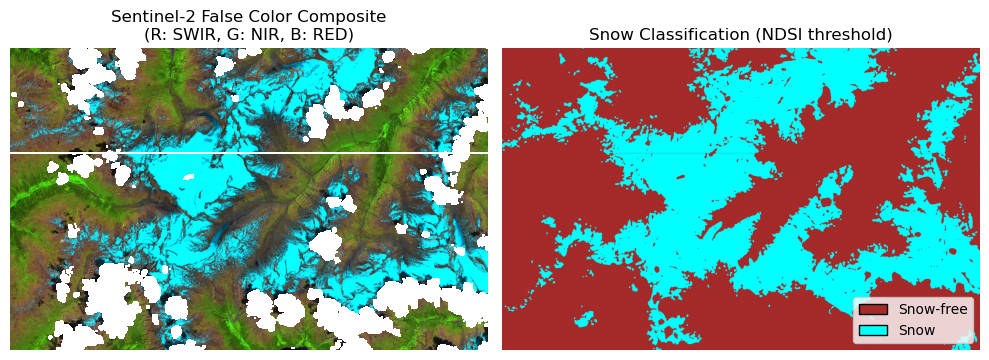

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot RGB image
axes[0].imshow(false_color_composite_masked.__xarray_dataarray_variable__)
axes[0].axis("off")
axes[0].set_title("Sentinel-2 False Color Composite\n(R: SWIR, G: NIR, B: RED)")

# Plot binary snow classification
binary_data = scl_snow_ice_map.scl.squeeze("time")

# Define discrete colormap: 0 = no snow (light gray), 1 = snow (blue)
cmap = ListedColormap(["brown", "cyan"])

im = axes[1].imshow(binary_data, cmap=cmap)
axes[1].axis("off")
axes[1].set_title("Snow Classification (NDSI threshold)")

# Create custom legend
legend_elements = [
    Patch(facecolor="brown", edgecolor="k", label="Snow-free"),
    Patch(facecolor="cyan", edgecolor="k", label="Snow"),
]

axes[1].legend(handles=legend_elements, loc="lower right")

plt.tight_layout()
plt.show()

## Visualize with JupyterGIS

In [4]:
# Extract coordinate information for map centering
lon_coords = false_color_composite_masked.x.values
lat_coords = false_color_composite_masked.y.values

# Calculate center point (assuming UTM coordinates, convert if needed)
center_x = (lon_coords.min() + lon_coords.max()) / 2
center_y = (lat_coords.min() + lat_coords.max()) / 2

# If coordinates are in UTM, we need to convert to lat/lon for map center
# For UTM Zone 32N (EPSG:32632), approximate conversion for display
# You might need to adjust these values based on your actual CRS
map_center_lat = 46.825  # Approximate center of your study area
map_center_lon = 10.8    # Approximate center of your study area

# Create JupyterGIS document
doc = GISDocument(
    path="Sentinel-2_NSDI_Snow_Mapping_JupyterGIS.jGIS",
    latitude=map_center_lat,
    longitude=map_center_lon,
    zoom=11
)

# Add base map
doc.add_raster_layer(
    url="https://tile.openstreetmap.org/{z}/{x}/{y}.png",
    name="OpenStreetMap"
)

'93c8ebab-c150-4164-9c49-663f5f40f877'

In [5]:
# Extract the DataArrays from the datasets
false_color = false_color_composite_masked.__xarray_dataarray_variable__
snow_map = scl_snow_ice_map.scl

print(f"\nData shapes:")
print(f"False color: {false_color.shape}")
print(f"Snow map: {snow_map.shape}")

# Set coordinate reference system (CRS) - assuming UTM Zone 32N for your study area
if false_color.rio.crs is None:
    false_color = false_color.rio.write_crs("EPSG:32632")
if snow_map.rio.crs is None:
    snow_map = snow_map.rio.write_crs("EPSG:32632")

print("Set CRS to EPSG:32632 (UTM Zone 32N)")

# Transpose false color data to correct dimension order for rioxarray
# Expected order: (bands, y, x)
if false_color.dims != ('bands', 'y', 'x'):
    false_color_transposed = false_color.transpose('bands', 'y', 'x')
    print(f"Transposed false color dimensions: {false_color_transposed.dims}")
else:
    false_color_transposed = false_color

# Convert boolean snow map to integer for reprojection
snow_map_int = snow_map.astype('uint8')
print("Converted snow map from boolean to uint8")

# Reproject both datasets to Web Mercator (EPSG:3857) for JupyterGIS compatibility
print("Reprojecting to EPSG:3857...")
false_color_3857 = false_color_transposed.rio.reproject("EPSG:3857")
snow_map_3857 = snow_map_int.rio.reproject("EPSG:3857")

print("Successfully reprojected to EPSG:3857")
print(f"False color new shape: {false_color_3857.shape}")
print(f"Snow map new shape: {snow_map_3857.shape}")

# Create output directory for processed files
output_dir = Path("./jupytergis_data")
output_dir.mkdir(exist_ok=True)

# Save snow map as GeoTIFF (works well with add_tiff_layer)
snow_map_path = output_dir / "snow_map_3857.tif"
snow_map_3857.rio.to_raster(snow_map_path)
print(f"Saved snow map as: {snow_map_path}")


Data shapes:
False color: (1960, 3095, 3)
Snow map: (1, 1960, 3095)
Set CRS to EPSG:32632 (UTM Zone 32N)
Transposed false color dimensions: ('bands', 'y', 'x')
Converted snow map from boolean to uint8
Reprojecting to EPSG:3857...
Successfully reprojected to EPSG:3857
False color new shape: (3, 2035, 3136)
Snow map new shape: (1, 2035, 3136)
Saved snow map as: jupytergis_data/snow_map_3857.tif


# Create PNG image from false color composite for better display

In [6]:
def create_false_color_png(data_array, output_path):
    """Convert false color xarray to PNG for display in JupyterGIS"""
    # Get data as numpy array and handle dimensions
    data = data_array.values  # Shape: (bands, height, width)
    
    # Convert to format for PIL (height, width, channels)
    data_clean = np.nan_to_num(data, nan=0.0)
    data_transposed = np.transpose(data_clean, (1, 2, 0))  # (height, width, 3)
    
    # Clip to 0-1 range and convert to 0-255
    data_display = np.clip(data_transposed * 255, 0, 255).astype(np.uint8)
    
    # Create and save PIL Image
    img = Image.fromarray(data_display)
    img.save(output_path, 'PNG', optimize=True)


# Create PNG version of false color composite
false_color_png = output_dir / "false_color.png"
create_false_color_png(false_color_3857, false_color_png)
print(f"Created PNG: {false_color_png}")

Created PNG: jupytergis_data/false_color.png


In [7]:
# Colored snow map function
def create_colored_snow_map(data_array, output_path):
    """Create RGB colored version with proper binary classification"""
    data = data_array.values.squeeze()
    
    # Create RGB image: 3 channels (R, G, B)
    height, width = data.shape
    rgb_data = np.zeros((height, width, 3), dtype=np.uint8)
    
    # Get unique values
    unique_vals = np.unique(data)
    print(f"Unique values: {unique_vals}")
    
    if len(unique_vals) == 2:
        # Pure binary case
        low_val, high_val = unique_vals
        print(f"Binary mapping: {low_val} -> Red, {high_val} -> Cyan")
        
        # Snow-free (lower value): Pure Red
        rgb_data[data == low_val] = [255, 0, 0]
        # Snow (higher value): Pure Cyan  
        rgb_data[data == high_val] = [0, 255, 255]
        
    else:
        # Multiple values - use threshold
        threshold = np.median(unique_vals)
        print(f"Multi-value case, using threshold: {threshold}")
        
        # Snow-free (below threshold): Pure Red
        rgb_data[data < threshold] = [255, 0, 0]
        # Snow (above threshold): Pure Cyan
        rgb_data[data >= threshold] = [0, 255, 255]
    
    # Verify no mixing occurred
    red_pixels = np.sum((rgb_data[:,:,0] == 255) & (rgb_data[:,:,1] == 0) & (rgb_data[:,:,2] == 0))
    cyan_pixels = np.sum((rgb_data[:,:,0] == 0) & (rgb_data[:,:,1] == 255) & (rgb_data[:,:,2] == 255))
    black_pixels = np.sum(np.all(rgb_data == 0, axis=2))
    
    print(f"Result: {red_pixels} red pixels, {cyan_pixels} cyan pixels, {black_pixels} black pixels")
    
    # Save image
    img = Image.fromarray(rgb_data)
    img.save(output_path, 'PNG', optimize=True)


# Run the debug and create fixed colored map
snow_map_colored_png = output_dir / "snow_map_colored.png"
create_colored_snow_map(snow_map_3857, snow_map_colored_png)

print(f"Created colored snow map: {snow_map_colored_png}")
print("Colors: Red = Snow-free, Cyan = Snow")

Unique values: [  0   1 255]
Multi-value case, using threshold: 1.0
Result: 4003153 red pixels, 2378607 cyan pixels, 0 black pixels
Created colored snow map: jupytergis_data/snow_map_colored.png
Colors: Red = Snow-free, Cyan = Snow


In [8]:
# Get bounds from the data array directly
bounds_3857 = false_color_3857.rio.bounds()

# Convert bounds to lat/lon for map centering and image overlay
transformer = pyproj.Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)
center_x = (bounds_3857[0] + bounds_3857[2]) / 2  # (left + right) / 2
center_y = (bounds_3857[1] + bounds_3857[3]) / 2  # (bottom + top) / 2
center_lon, center_lat = transformer.transform(center_x, center_y)

# Get corners for PNG image overlay
sw_lon, sw_lat = transformer.transform(bounds_3857[0], bounds_3857[1])  # left, bottom
ne_lon, ne_lat = transformer.transform(bounds_3857[2], bounds_3857[3])  # right, top

print(f"Map center: {center_lat:.6f}, {center_lon:.6f}")
print(f"Data extent: ({sw_lat:.6f}, {sw_lon:.6f}) to ({ne_lat:.6f}, {ne_lon:.6f})")

# Calculate appropriate zoom level
lat_span = ne_lat - sw_lat
lon_span = ne_lon - sw_lon
max_span = max(lat_span, lon_span)

# Add false color composite as PNG image overlay
doc.add_image_layer(
    url=str(false_color_png),
    coordinates=[
        [sw_lon, ne_lat],  # Top-left
        [ne_lon, ne_lat],  # Top-right
        [ne_lon, sw_lat],  # Bottom-right
        [sw_lon, sw_lat]   # Bottom-left
    ],
    name="False Color Composite (SWIR-NIR-RED)",
    opacity=0.8
)

# Add snow classification as GeoTIFF (original grayscale)
doc.add_tiff_layer(
    url=str(snow_map_path),
    name="Snow/Ice Classification (Grayscale)",
    opacity=0.7
)

# Add colored snow map as PNG image overlay
doc.add_image_layer(
    url=str(snow_map_colored_png),
    coordinates=[
        [sw_lon, ne_lat],  # Top-left
        [ne_lon, ne_lat],  # Top-right
        [ne_lon, sw_lat],  # Bottom-right
        [sw_lon, sw_lat]   # Bottom-left
    ],
    name="Snow/Ice Classification (Colored: Red=Snow-free, Cyan=Snow)",
    opacity=0.7
)

# Display the interactive map
doc

Map center: 46.825072, 10.800639
Data extent: (46.733650, 10.594911) to (46.916339, 11.006368)


In [9]:
# Calculate and display statistics
snow_pixels = snow_map.sum().compute()
total_pixels = (~np.isnan(snow_map)).sum().compute()
snow_percentage = (snow_pixels / total_pixels * 100).values

print("\n" + "="*50)
print("INTERACTIVE SNOW MAPPING COMPLETE")
print("="*50)
print(f"Study Area: Oetztal Alps")
print(f"Data: Sentinel-2 L2A")
print(f"Snow Coverage: {snow_percentage:.1f}% of study area")
print(f"Snow pixels: {snow_pixels.values:,}")
print(f"Total valid pixels: {total_pixels.values:,}")
print("\nAvailable Layers:")
print("• OpenStreetMap (base map)")
print("• False Color Composite (SWIR-NIR-RED)")
print("• Snow/Ice Classification (Grayscale)")
print("• Snow/Ice Classification (Colored: Red=Snow-free, Cyan=Snow)")
print("\nUse layer controls to toggle visibility and adjust opacity")
print("Toggle between grayscale and colored snow maps for different visualization needs")



INTERACTIVE SNOW MAPPING COMPLETE
Study Area: Oetztal Alps
Data: Sentinel-2 L2A
Snow Coverage: 34.1% of study area
Snow pixels: 2,067,630
Total valid pixels: 6,066,200

Available Layers:
• OpenStreetMap (base map)
• False Color Composite (SWIR-NIR-RED)
• Snow/Ice Classification (Grayscale)
• Snow/Ice Classification (Colored: Red=Snow-free, Cyan=Snow)

Use layer controls to toggle visibility and adjust opacity
Toggle between grayscale and colored snow maps for different visualization needs
